# Experimento 14

Se incluye una regresion lineal al final, se utiliza el modelo del experimento 13

In [1]:
import os
import numpy as np
import imageio
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("GPU detectada:", tf.test.gpu_device_name())

GPU detectada: /device:GPU:0


In [4]:
# Rutas de los conjuntos de entrenamiento y validación
train_path = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Training+Density/'
val_path   = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Validation+Density/'

In [5]:
# Función para leer y preprocesar datos
def read_data(base_path, density_threshold=400):
    data = []
    anno = []
    file_list = os.listdir(base_path)
    for filename in file_list:
        if 'Density' in filename:
            base_filename = filename[:-11] + '.tif'
            img_path = os.path.join(base_path, base_filename)
            dens_path = os.path.join(base_path, filename)
            if os.path.exists(img_path) and os.path.exists(dens_path):
                # Cargar imagen y normalizar a [0,1]
                img = np.asarray(Image.open(img_path).convert("RGB")).astype(np.float32) / 255.0
                # Cargar mapa de densidad
                density = imageio.imread(dens_path).astype(np.float32)
                # Filtrado basado en la suma (ajustar el umbral)
                if np.sum(density) / 100 < density_threshold:
                    data.append(img)
                    # Expandir la dimensión para que tenga forma (H, W, 1)
                    density = np.expand_dims(density, axis=-1)
                    anno.append(density)
    return np.array(data), np.array(anno)

In [6]:
# Cargar conjuntos de entrenamiento y validación
train_images, train_density_maps = read_data(train_path, density_threshold=400)
val_images, val_density_maps = read_data(val_path, density_threshold=400)

print("Train images shape:", train_images.shape)
print("Train density maps shape:", train_density_maps.shape)
print("Validation images shape:", val_images.shape)
print("Validation density maps shape:", val_density_maps.shape)

<ipython-input-5-334694396>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  density = imageio.imread(dens_path).astype(np.float32)


Train images shape: (184, 256, 256, 3)
Train density maps shape: (184, 256, 256, 1)
Validation images shape: (80, 256, 256, 3)
Validation density maps shape: (80, 256, 256, 1)


In [7]:
# Función de data augmentation (flip y rotaciones)
def augment(image, density):
    # Flip horizontal aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        density = tf.image.flip_left_right(density)
    # Flip vertical aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        density = tf.image.flip_up_down(density)
    # Rotación aleatoria múltiplo de 90 grados
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    density = tf.image.rot90(density, k)
    return image, density

# Crear datasets tf.data para entrenamiento y validación
batch_size = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_density_maps))
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), tf.image.resize(y, (256,256))))
train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_density_maps))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), tf.image.resize(y, (256,256))))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
print("Número de batches en entrenamiento:", len(list(train_dataset)))

Número de batches en entrenamiento: 23


El dataset de entrenamiento es de 23 batches, cada batch tiene 8 imagenes, por lo que en total tenemos 184 imagenes.

## Modelo u-net

In [9]:
#Construcción del modelo U-Net mejorado
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

# Entrada del modelo
inputs = layers.Input(shape=(256,256,3))

# Encoder
c1, p1 = encoder_block(inputs, 16)
c2, p2 = encoder_block(p1, 32)
c3, p3 = encoder_block(p2, 64)

# Cuello de botella con Dropout para regularización
b = conv_block(p3, 128)
b = layers.Dropout(0.5)(b)

# Decoder
def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x

d1 = decoder_block(b, c3, 64)
d2 = decoder_block(d1, c2, 32)
d3 = decoder_block(d2, c1, 16)

# Salida: Mapa de densidad con activación ReLU para evitar valores negativos
outputs = layers.Conv2D(1, (1,1), activation='relu')(d3)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 538,609 (2.05 MB)

 Trainable params: 537,201 (2.05 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Compilacion y entrenamiento

In [10]:
# Compilar el modelo
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mae'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo usando el pipeline de tf.data
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    callbacks=[early_stop, reduce_lr, checkpoint])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.2946 - mae: 0.9419

23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 170ms/step - loss: 2.2908 - mae: 0.9410 - val_loss: 1.3598 - val_mae: 0.2144 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.9235 - mae: 0.8187

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.9196 - mae: 0.8170 - val_loss: 1.3594 - val_mae: 0.2437 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.6332 - mae: 0.6547

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 1.6333 - mae: 0.6534 - val_loss: 1.3567 - val_mae: 0.3119 - learning_rate: 1.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.5509 - mae: 0.5180

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 1.5504 - mae: 0.5169 - val_loss: 1.3522 - val_mae: 0.3550 - learning_rate: 1.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.5748 - mae: 0.4337

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.5720 - mae: 0.4328 - val_loss: 1.3503 - val_mae: 0.3663 - learning_rate: 1.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.5555 - mae: 0.3800

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.5530 - mae: 0.3796 - val_loss: 1.3487 - val_mae: 0.3602 - learning_rate: 1.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.5263 - mae: 0.3582

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 1.5249 - mae: 0.3580 - val_loss: 1.3481 - val_mae: 0.3466 - learning_rate: 1.0000e-04
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.4245 - mae: 0.3330

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.4271 - mae: 0.3332 - val_loss: 1.3480 - val_mae: 0.3308 - learning_rate: 1.0000e-04
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.4522 - mae: 0.3344

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 1.4537 - mae: 0.3347 - val_loss: 1.3473 - val_mae: 0.3202 - learning_rate: 1.0000e-04
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.4574 - mae: 0.3371

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.4585 - mae: 0.3373 - val_loss: 1.3468 - val_mae: 0.3053 - learning_rate: 1.0000e-04
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.5646 - mae: 0.3469

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.5612 - mae: 0.3466 - val_loss: 1.3463 - val_mae: 0.2953 - learning_rate: 1.0000e-04
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.4973 - mae: 0.3346 - val_loss: 1.3468 - val_mae: 0.2783 - learning_rate: 1.0000e-04
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.5411 - mae: 0.3434 - val_loss: 1.3480 - val_mae: 0.2649 - learning_rate: 1.0000e-04
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 1.4750 - mae: 0.3331 - val_loss: 1.3464 - val_mae: 0.2566 - learning_rate: 1.0000e-04
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.5559 - mae: 0.3418

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 1.5526 - mae: 0.3414 - val_loss: 1.3433 - val_mae: 0.2608 - learning_rate: 5.0000e-05
Epoch 16/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.4388 - mae: 0.3264

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.4403 - mae: 0.3266 - val_loss: 1.3426 - val_mae: 0.2528 - learning_rate: 5.0000e-05
Epoch 17/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.4830 - mae: 0.3353

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.4826 - mae: 0.3353 - val_loss: 1.3410 - val_mae: 0.2575 - learning_rate: 5.0000e-05
Epoch 18/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.5236 - mae: 0.3364

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.5214 - mae: 0.3363 - val_loss: 1.3396 - val_mae: 0.2539 - learning_rate: 5.0000e-05
Epoch 19/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.5216 - mae: 0.3382

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.5195 - mae: 0.3381 - val_loss: 1.3353 - val_mae: 0.2597 - learning_rate: 5.0000e-05
Epoch 20/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.5420 - mae: 0.3389

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.5389 - mae: 0.3386 - val_loss: 1.3347 - val_mae: 0.2607 - learning_rate: 5.0000e-05
Epoch 21/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.5463 - mae: 0.3416 - val_loss: 1.3363 - val_mae: 0.2687 - learning_rate: 5.0000e-05
Epoch 22/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4711 - mae: 0.3286

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 1.4708 - mae: 0.3286 - val_loss: 1.3266 - val_mae: 0.2691 - learning_rate: 5.0000e-05
Epoch 23/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.5211 - mae: 0.3337

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.5186 - mae: 0.3335 - val_loss: 1.3208 - val_mae: 0.2861 - learning_rate: 5.0000e-05
Epoch 24/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4578 - mae: 0.3257

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.4578 - mae: 0.3258 - val_loss: 1.3149 - val_mae: 0.2885 - learning_rate: 5.0000e-05
Epoch 25/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4563 - mae: 0.3261

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 1.4562 - mae: 0.3261 - val_loss: 1.2999 - val_mae: 0.3078 - learning_rate: 5.0000e-05
Epoch 26/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.4733 - mae: 0.3266 - val_loss: 1.3056 - val_mae: 0.3159 - learning_rate: 5.0000e-05
Epoch 27/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4296 - mae: 0.3207 - val_loss: 1.3058 - val_mae: 0.3124 - learning_rate: 5.0000e-05
Epoch 28/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4534 - mae: 0.3283

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.4532 - mae: 0.3282 - val_loss: 1.2905 - val_mae: 0.3056 - learning_rate: 5.0000e-05
Epoch 29/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.4721 - mae: 0.3267 - val_loss: 1.3023 - val_mae: 0.2910 - learning_rate: 5.0000e-05
Epoch 30/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4469 - mae: 0.3226 - val_loss: 1.2936 - val_mae: 0.3084 - learning_rate: 5.0000e-05
Epoch 31/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4267 - mae: 0.3212

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.4272 - mae: 0.3214 - val_loss: 1.2875 - val_mae: 0.3100 - learning_rate: 5.0000e-05
Epoch 32/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.4584 - mae: 0.3219 - val_loss: 1.2947 - val_mae: 0.3073 - learning_rate: 5.0000e-05
Epoch 33/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.4586 - mae: 0.3227

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.4576 - mae: 0.3227 - val_loss: 1.2866 - val_mae: 0.3076 - learning_rate: 5.0000e-05
Epoch 34/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.3950 - mae: 0.3121

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 1.3965 - mae: 0.3123 - val_loss: 1.2842 - val_mae: 0.3301 - learning_rate: 5.0000e-05
Epoch 35/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4140 - mae: 0.3171 - val_loss: 1.2859 - val_mae: 0.3129 - learning_rate: 5.0000e-05
Epoch 36/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4712 - mae: 0.3254

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.4695 - mae: 0.3253 - val_loss: 1.2799 - val_mae: 0.3012 - learning_rate: 5.0000e-05
Epoch 37/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.4227 - mae: 0.3160 - val_loss: 1.2914 - val_mae: 0.2895 - learning_rate: 5.0000e-05
Epoch 38/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.4776 - mae: 0.3305

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 1.4755 - mae: 0.3303 - val_loss: 1.2741 - val_mae: 0.3090 - learning_rate: 5.0000e-05
Epoch 39/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.4370 - mae: 0.3131 - val_loss: 1.2743 - val_mae: 0.3129 - learning_rate: 5.0000e-05
Epoch 40/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.4440 - mae: 0.3188 - val_loss: 1.2825 - val_mae: 0.3091 - learning_rate: 5.0000e-05
Epoch 41/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4668 - mae: 0.3209 - val_loss: 1.2830 - val_mae: 0.3081 - learning_rate: 5.0000e-05
Epoch 42/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.4753 - mae: 0.3230 - val_loss: 1.2776 - val_mae: 0.3026 - learning_rate: 2.5000e-05
Epoch 43/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.4219 - mae: 0.3129 - val_loss: 1.2766 - val_mae: 0.3130 - learning_rate: 2.5000e-05


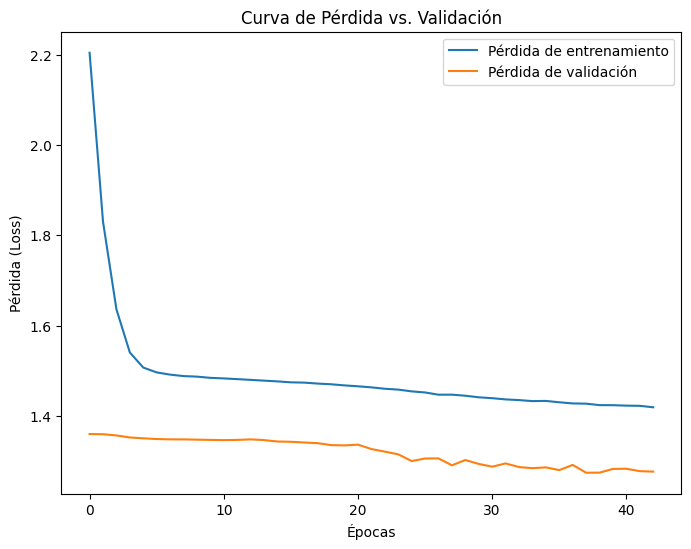

In [11]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.title('Curva de Pérdida vs. Validación')
plt.legend()
plt.show()

In [12]:
# Evaluación del modelo
model.load_weights('best_model.h5')
val_loss, val_mae = model.evaluate(val_dataset)
print(f"Validación - MSE: {val_loss:.3f}, MAE: {val_mae:.3f}")

# Predicción y visualización en una imagen de val
for test_img, true_density in val_dataset.take(1):
    test_img_sample = test_img[1]
    true_density_sample = true_density[1]

predicted_map = model.predict(tf.expand_dims(test_img_sample, axis=0)).squeeze()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1516 - mae: 0.2902
Validación - MSE: 1.274, MAE: 0.309
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


`tf.expand_dims(test_img_sample, axis=0)` agrega una dimensión al tensor para que pase de `(256, 256, 3)` a `(1, 256, 256, 3)`. El "1" indica el tamaño del batch. Esto es porque el modelo espera un input en lote.

`squeeze` elimina la dimensión de tamaño 1. Esto para eliminar lo adicionado anteriormente.

Conteo real: 5400.00 | Conteo predicho: 10424.64


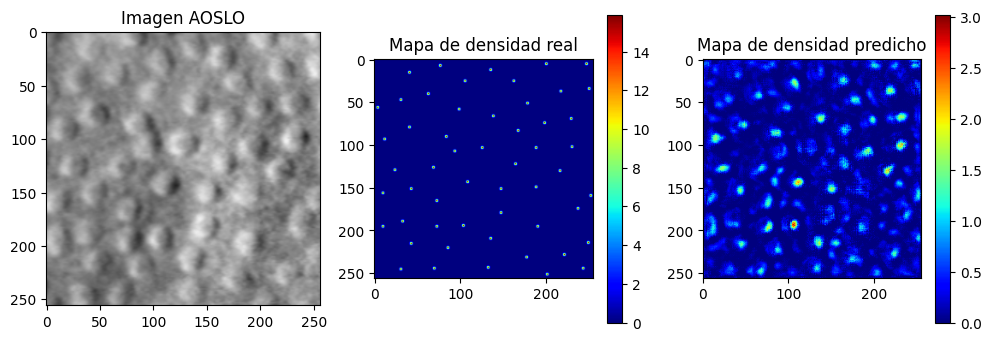

In [13]:
# Cálculo del conteo (suma del mapa)
true_count = np.sum(true_density_sample)
pred_count = np.sum(predicted_map)
print(f"Conteo real: {true_count:.2f} | Conteo predicho: {pred_count:.2f}")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(test_img_sample)
plt.title("Imagen AOSLO")

plt.subplot(1,3,2)
plt.imshow(true_density_sample[:,:,0], cmap='jet')
plt.title("Mapa de densidad real")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(predicted_map, cmap='jet')
plt.title("Mapa de densidad predicho")
plt.colorbar()

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


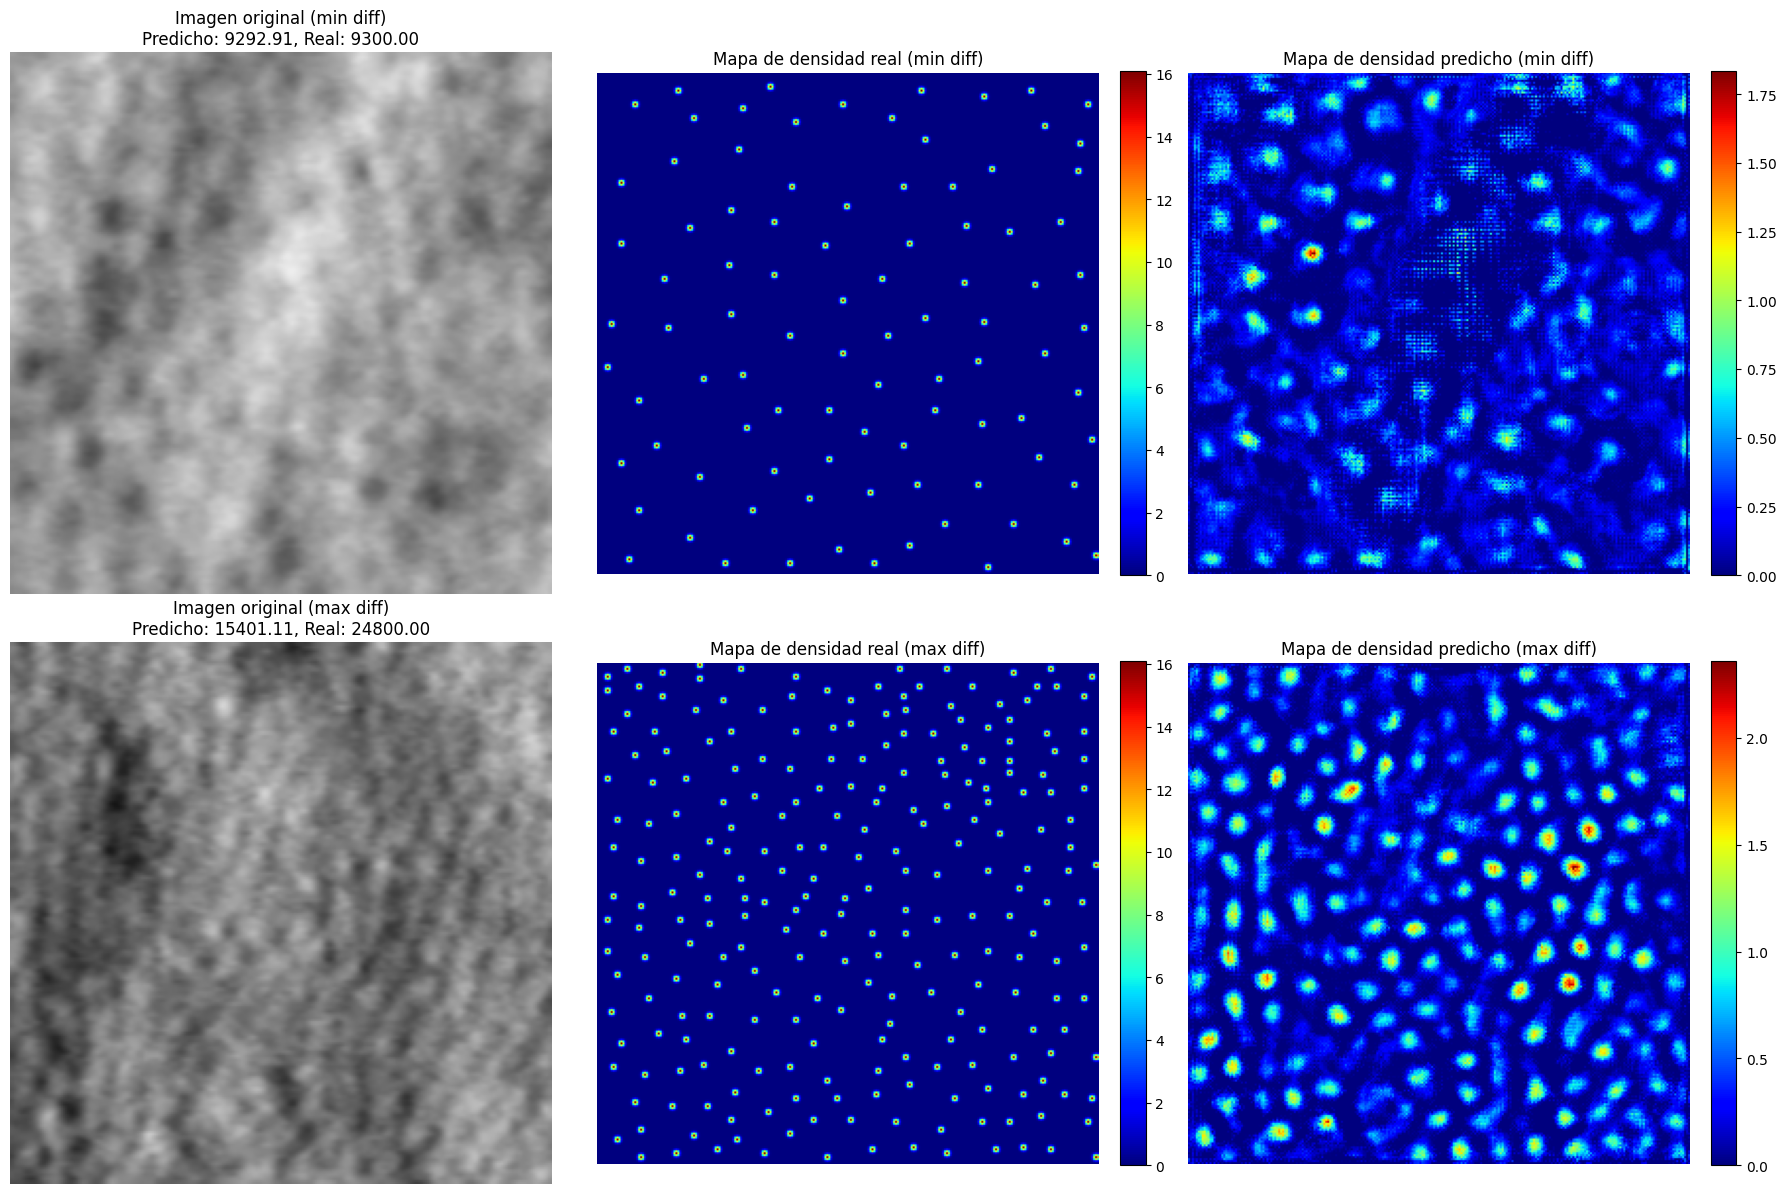

In [14]:

# Acumular todas las imágenes y mapas de densidad del conjunto de validación
val_images_all = []
val_density_all = []

for test_img, true_density in val_dataset:
    # Convertimos cada batch a numpy y lo acumulamos
    val_images_all.append(test_img.numpy())
    val_density_all.append(true_density.numpy())

# Concatenar todos los batches en un solo array
val_images_all = np.concatenate(val_images_all, axis=0)
val_density_all = np.concatenate(val_density_all, axis=0)

# Realizar predicciones en todas las imágenes de validación
val_predictions = model.predict(val_images_all)

# Calcular el conteo total (suma del mapa) para cada imagen
pred_counts = np.sum(val_predictions, axis=(1,2,3))
true_counts = np.sum(val_density_all, axis=(1,2,3))

# Calcular la diferencia absoluta entre el conteo real y el predicho
diff = np.abs(true_counts - pred_counts)

# Obtener los índices de la imagen con menor y mayor diferencia
min_idx = np.argmin(diff)
max_idx = np.argmax(diff)

# Preparar la gráfica para las imágenes con menor y mayor diferencia
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Caso de menor diferencia
min_pred_count = pred_counts[min_idx]
min_true_count = true_counts[min_idx]

# Imagen original con anotación en el título
axes[0, 0].imshow(val_images_all[min_idx])
axes[0, 0].set_title(f'Imagen original (min diff)\nPredicho: {min_pred_count:.2f}, Real: {min_true_count:.2f}')
axes[0, 0].axis('off')

# Mapa de densidad real con escala de colores
im_real_min = axes[0, 1].imshow(val_density_all[min_idx].squeeze(), cmap='jet')
axes[0, 1].set_title('Mapa de densidad real (min diff)')
axes[0, 1].axis('off')
plt.colorbar(im_real_min, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Mapa de densidad predicho con escala de colores
im_pred_min = axes[0, 2].imshow(val_predictions[min_idx].squeeze(), cmap='jet')
axes[0, 2].set_title('Mapa de densidad predicho (min diff)')
axes[0, 2].axis('off')
plt.colorbar(im_pred_min, ax=axes[0, 2], fraction=0.046, pad=0.04)

# Caso de mayor diferencia
max_pred_count = pred_counts[max_idx]
max_true_count = true_counts[max_idx]

# Imagen original con anotación en el título
axes[1, 0].imshow(val_images_all[max_idx])
axes[1, 0].set_title(f'Imagen original (max diff)\nPredicho: {max_pred_count:.2f}, Real: {max_true_count:.2f}')
axes[1, 0].axis('off')

# Mapa de densidad real con escala de colores
im_real_max = axes[1, 1].imshow(val_density_all[max_idx].squeeze(), cmap='jet')
axes[1, 1].set_title('Mapa de densidad real (max diff)')
axes[1, 1].axis('off')
plt.colorbar(im_real_max, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Mapa de densidad predicho con escala de colores
im_pred_max = axes[1, 2].imshow(val_predictions[max_idx].squeeze(), cmap='jet')
axes[1, 2].set_title('Mapa de densidad predicho (max diff)')
axes[1, 2].axis('off')
plt.colorbar(im_pred_max, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

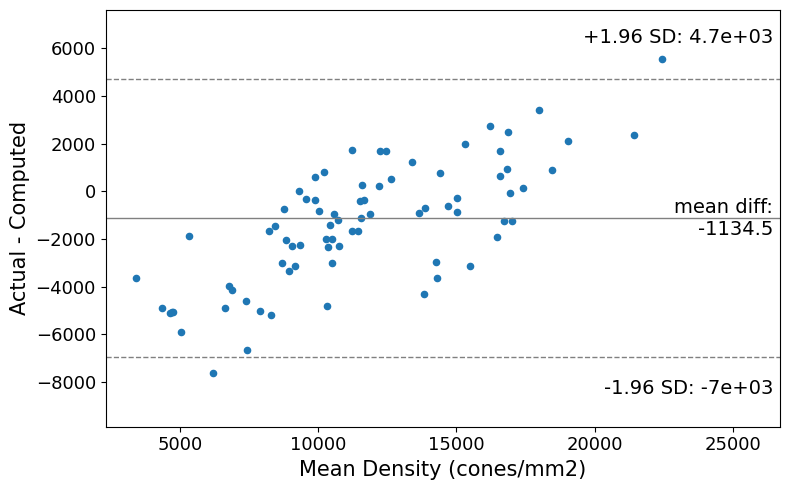

In [15]:
# Gráfico de mean-diff (Bland–Altman)
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(true_counts, pred_counts, ax=ax)

plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

# Regresión Lineal

In [16]:
def predict_counts(dataset, model):
    preds, true_maps = [], []
    for imgs, dens in dataset:
        preds.append(model.predict(imgs))
        true_maps.append(dens.numpy())
    preds = np.concatenate(preds, axis=0)
    true_maps = np.concatenate(true_maps, axis=0)
    counts_pred = np.sum(preds, axis=(1, 2, 3))
    counts_true = np.sum(true_maps, axis=(1, 2, 3))
    return counts_pred, counts_true

## Train

In [17]:
train_pred_counts, train_true_counts = predict_counts(train_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


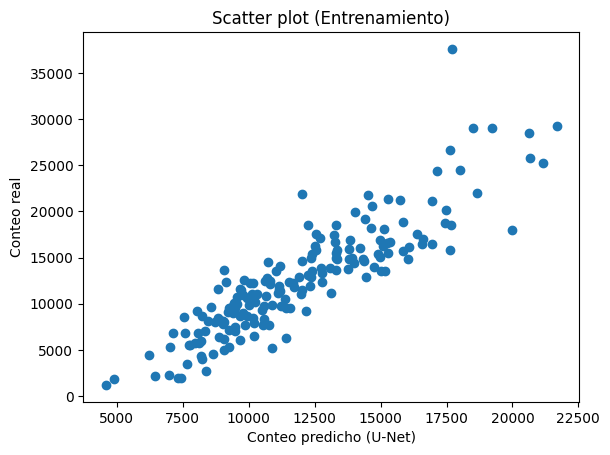

In [18]:
X_train = train_pred_counts.reshape(-1, 1) #Es necesario hacer reshape para que pase de (184,) a (184,1)
y_train = train_true_counts

plt.figure()
plt.scatter(X_train, y_train)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Scatter plot (Entrenamiento)")
plt.show()

## Val

In [19]:
# Obtener predicciones para el conjunto de validación
val_pred_counts, val_true_counts = predict_counts(val_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


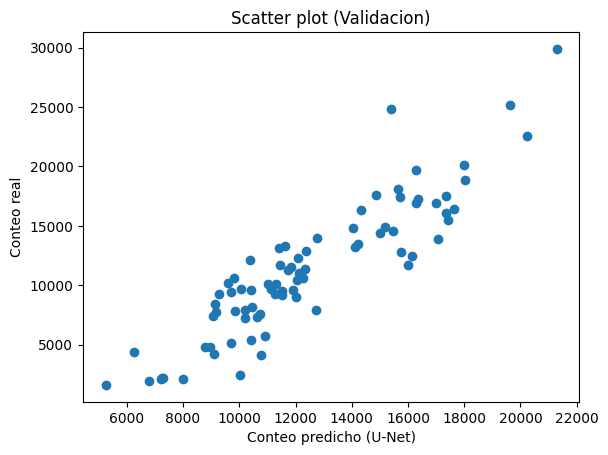

In [20]:
X_val = val_pred_counts.reshape(-1, 1)
y_val = val_true_counts

plt.figure()
plt.scatter(X_val, y_val)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Scatter plot (Validacion)")
plt.show()

## Regresión lineal

In [21]:
# Ajustar reg lineal
reg = LinearRegression().fit(X_train, y_train)

In [22]:
# parámetros del modelo
slope = reg.coef_[0]
intercept = reg.intercept_
print(f"Regresión lineal ajustada: y = {slope:.4f} * x + {intercept:.4f}")
print(f'Score en entrenamiento: {reg.score(X_train, y_train):.4f}')

Regresión lineal ajustada: y = 1.5782 * x + -6191.7188
Score en entrenamiento: 0.7874


In [23]:
# Evaluacion de la regresion sobre validacion
# Predecir conteos corregidos para el conjunto de validación
corrected_val_counts = reg.predict(X_val)

# Calcular el error absoluto medio (MAE) antes y después de la corrección
mae_before = mean_absolute_error(val_true_counts, val_pred_counts)
mae_after = mean_absolute_error(val_true_counts, corrected_val_counts)

# Calcular el error cuadrático medio (MSE) antes y después de la corrección
mse_before = mean_squared_error(val_true_counts, val_pred_counts)
mse_after = mean_squared_error(val_true_counts, corrected_val_counts)

# Imprimir resultados
print(f"MAE antes: {mae_before:.4f} | MAE después: {mae_after:.4f}")
print(f"MSE antes: {mse_before:.4f} | MSE después: {mse_after:.4f}")

MAE antes: 2446.7336 | MAE después: 2616.5496
MSE antes: 10127052.0000 | MSE después: 10570654.0000


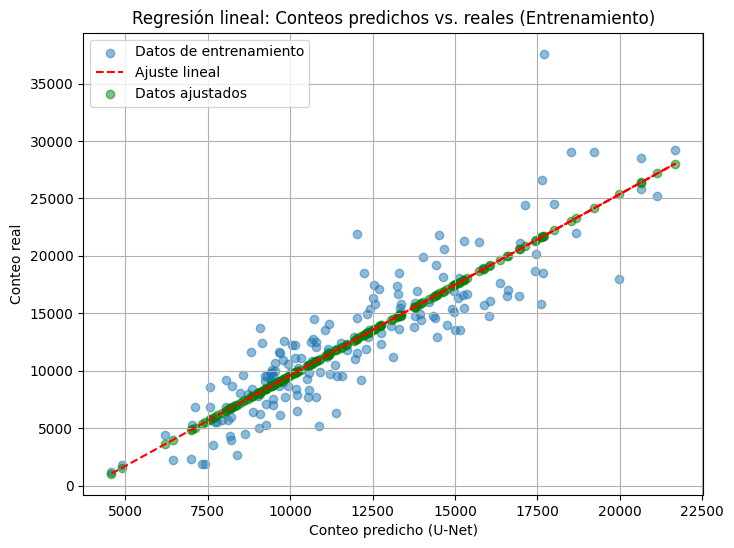

In [24]:
# Gráfico para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
plt.scatter(train_pred_counts, train_true_counts, label="Datos de entrenamiento", alpha=0.5)
plt.plot(train_pred_counts, reg.predict(X_train), color="red", linestyle='--', label="Ajuste lineal")
plt.scatter(X_train, reg.predict(X_train), color='green', label="Datos ajustados",alpha=0.5)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Regresión lineal: Conteos predichos vs. reales (Entrenamiento)")
plt.legend()
plt.grid(True)
plt.show()

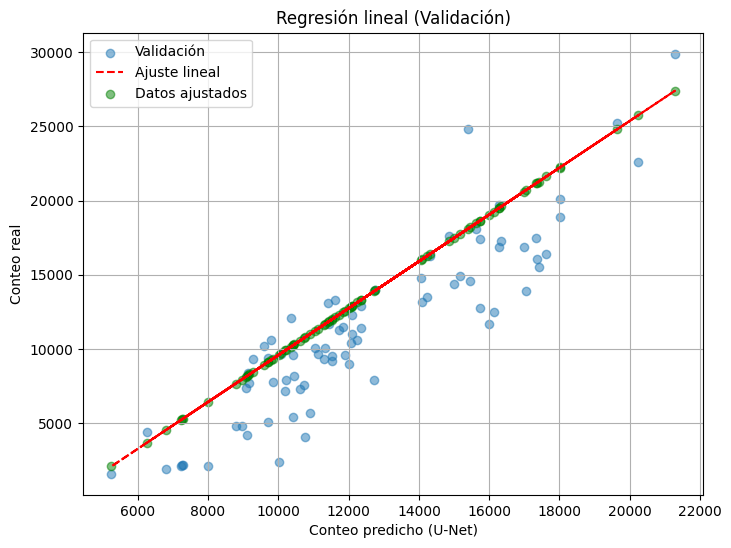

In [25]:
# Gráfico para el conjunto de validación
plt.figure(figsize=(8, 6))
plt.scatter(val_pred_counts, val_true_counts, label="Validación", alpha=0.5)
plt.plot(val_pred_counts, corrected_val_counts, color="red", linestyle='--', label="Ajuste lineal")
plt.scatter(X_val, corrected_val_counts, color='green', label="Datos ajustados",alpha=0.5)
plt.xlabel("Conteo predicho (U-Net)")
plt.ylabel("Conteo real")
plt.title("Regresión lineal (Validación)")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Ejemplo
# Tomar una imagen del conjunto de validación como ejemplo
test_img_sample = val_images_all[0]  # Primera imagen de validación
predicted_map = model.predict(tf.expand_dims(test_img_sample, axis=0)).squeeze()
pred_count = np.sum(predicted_map)

# Aplicar la corrección
corrected_count = reg.predict([[pred_count]])
print(f"Conteo original: {pred_count:.2f} | Conteo corregido: {corrected_count[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Conteo original: 9145.04 | Conteo corregido: 8241.42


# Grafico de Bland Altman

## Train

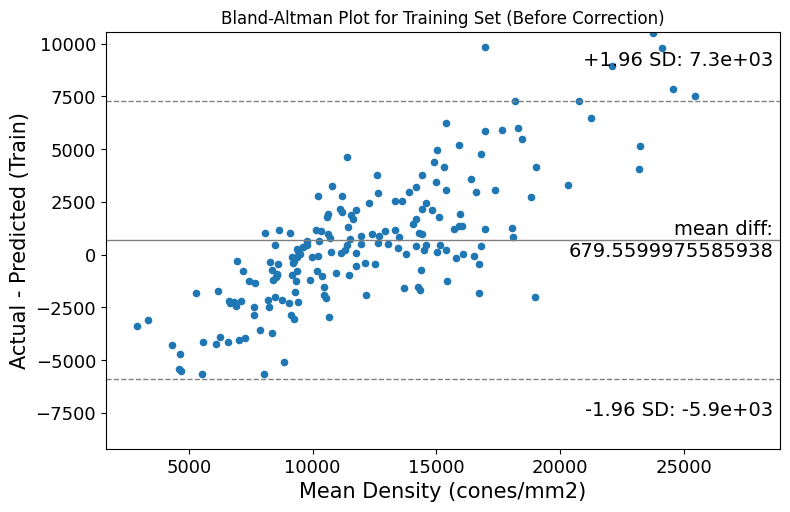

In [27]:
# Crear el gráfico de Bland-Altman
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(train_true_counts, train_pred_counts, ax=ax)

# Etiquetas y título
plt.ylabel('Actual - Predicted (Train)')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot for Training Set (Before Correction)')
plt.show()

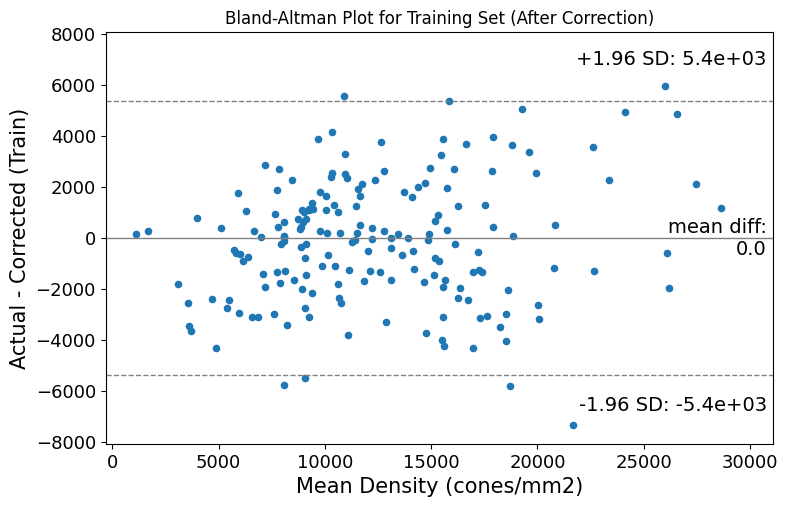

In [28]:
corrected_train_counts = reg.predict(X_train)

# Crear el gráfico de Bland-Altman
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(train_true_counts, corrected_train_counts, ax=ax)

# Etiquetas y título
plt.ylabel('Actual - Corrected (Train)')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot for Training Set (After Correction)')
plt.show()

## Validation

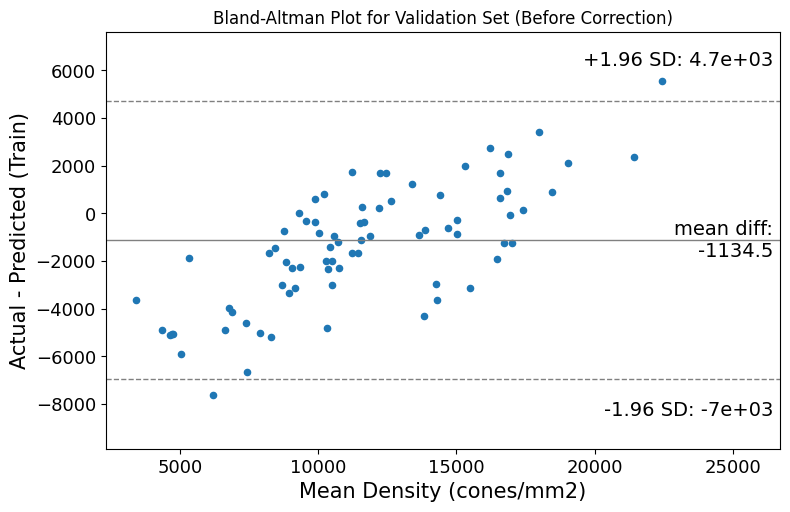

In [29]:
# Crear el gráfico de Bland-Altman
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(val_true_counts, val_pred_counts, ax=ax)

# Etiquetas y título
plt.ylabel('Actual - Predicted (Train)')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot for Validation Set (Before Correction)')
plt.show()

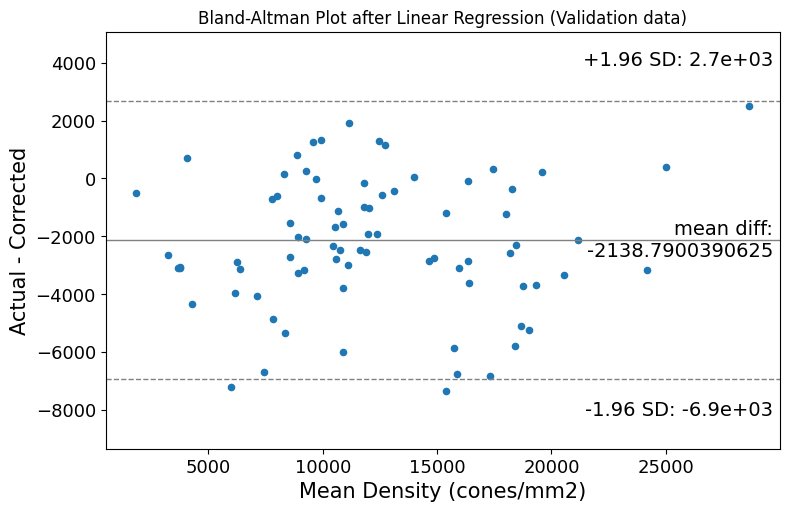

In [30]:
# Gráfico de mean-diff (Bland-Altman) después del ajuste lineal
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(val_true_counts, corrected_val_counts, ax=ax)

plt.ylabel('Actual - Corrected')
plt.xlabel('Mean Density (cones/mm2)')
plt.title('Bland-Altman Plot after Linear Regression (Validation data)')
plt.show()

In [31]:
from sklearn.metrics import r2_score

y_true, y_pred = [], []

# Recorremos todo el validation set sin alterar el grafo
for batch_x, batch_y in val_dataset:
    preds = model(batch_x, training=False)
    y_true.append(batch_y.numpy().ravel())
    y_pred.append(preds.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Métricas
mae  = np.mean(np.abs(y_true - y_pred))
mse  = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2   = r2_score(y_true, y_pred)
corr = np.corrcoef(y_true, y_pred)[0,1]

print(f"MAE : {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f} %")
print(f"R²  : {r2:.3f}")
print(f"ρ   : {corr:.3f}")

<ipython-input-31-536331858>:18: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-31-536331858>:18: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAE : 0.309
MSE: 1.274
RMSE: 1.129
MAPE: nan %
R²  : 0.053
ρ   : 0.232
